In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
os.chdir(project_root)

if project_root not in sys.path:
    sys.path.append(project_root)

print("Current dir:", os.getcwd())

Current dir: /Users/ricardojuancardenesperez/tfg/framework


In [2]:
import torch
import torch.nn as nn

from torch.nn.utils.rnn import pad_sequence
from functools import partial

In [ ]:
from playground.readers.MNISTMixedDataset.reader import Reader
from torch.utils.data import DataLoader

from playground.architectures.FixedConvolutionalImageAutoencoder import Builder as ImageBuilder
from playground.architectures.GRUSeq2seqBidirectional import(
    Builder as TextBuilder,
    Wrapper
)

from playground.trainers import MixedAdaptativeAnnealingTrainer
from playground.helpers.tokenizer import TextTokenizer

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataset

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor()
])

dataset = Reader(
    train=True,
    transform=transform,
    len=10000
)

In [7]:
dataset.tokenizer.save('models/align_conv_lstm_fashion_mnist_56x56/tokenizer.pkl')

In [8]:
for image, sequence in dataset:
    print(image.shape)
    print(sequence.shape)
    break

torch.Size([1, 56, 56])
torch.Size([6])


In [9]:
pad_idx = dataset.tokenizer.token2idx['<pad>']

In [10]:
def collate_fn(batch, max_len=30):
    images, sequences = zip(*batch)
    sequences = pad_sequence([seq.detach().clone() if isinstance(seq, torch.Tensor) else torch.tensor(seq).detach().clone() for seq in sequences], 
                             batch_first=True, padding_value=pad_idx)
    
    if sequences.size(1) < max_len:
        pad_len = max_len - sequences.size(1)
        pad_tensor = torch.full(
            (sequences.size(0), pad_len), 
            fill_value=pad_idx, 
            dtype=sequences.dtype
        )
        sequences = torch.cat([sequences, pad_tensor], dim=1)
    
    sequences = sequences[:, :max_len]
    images = torch.stack(images, dim=0)
    
    return images, sequences

In [11]:
loader = DataLoader(dataset, batch_size=32, collate_fn=partial(collate_fn, max_len=12), shuffle=True)

In [12]:
for i, (images, sequences) in enumerate(loader):
    print(images.shape)
    print(sequences.shape)
    break

torch.Size([32, 1, 56, 56])
torch.Size([32, 12])


# Models

In [13]:
image_size = 56
input_channels = 1
latent_dim = 30

In [14]:
builder = ImageBuilder()
image_model = builder.build(
    image_size,
    input_channels,
    latent_dim
)

In [15]:
image_model.train()

ImageVAE(
  (encoder): ConvolutionalEncoder(
    (fc1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (mu_proj): Linear(in_features=6272, out_features=30, bias=True)
    (logvar_proj): Linear(in_features=6272, out_features=30, bias=True)
  )
  (decoder): ConvolutionalDecoder(
    (latent_proj): Linear(in_features=30, out_features=6272, bias=True)
    (fc4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (fc5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (fc6): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [16]:
vocab_size = len(dataset.tokenizer.vocab)

In [17]:
builder = TextBuilder()
text_model = builder.build(
    vocab_size=vocab_size,
    embedding_dim=64,
    hidden_dim=64,
    latent_dim=latent_dim,
    context_length=12,
    num_layers=1
)

In [18]:
wrapper = Wrapper(text_model)

In [19]:
wrapper.train()

WrapperGRU(
  (model): TextVAE(
    (embedding): Embedding(24, 64)
    (encoder): BidirectionalEncoder(
      (encoder): GRU(64, 64, batch_first=True, bidirectional=True)
      (mu_proj): Sequential(
        (0): Linear(in_features=128, out_features=30, bias=True)
      )
      (sigma_proj): Sequential(
        (0): Linear(in_features=128, out_features=30, bias=True)
      )
    )
    (decoder): AutoregressiveDecoder(
      (embedding): Embedding(24, 64)
      (proj_h): Linear(in_features=30, out_features=64, bias=True)
      (decoder): GRU(64, 64, batch_first=True)
      (fc): Linear(in_features=64, out_features=24, bias=True)
    )
  )
)

# Training

In [20]:
params = list(image_model.parameters()) + list(text_model.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3, betas=(0.5, 0.999), weight_decay=1e-5)

image_criteria = nn.BCELoss(reduction='mean')
text_criteria = nn.CrossEntropyLoss(ignore_index=pad_idx, reduction='mean')

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_model.to(device)
text_model.to(device)

image_model.train()
text_model.train();

In [22]:
weights = {'text_model_loss': 10, 'image_model_loss': 1e3, 'text_kd_loss': 1, 'image_kd_loss': 1, 'align_loss': 100}

In [23]:
trainer = MixedAdaptativennealingTrainer(
    wrapper,
    image_model,
    text_criteria,
    image_criteria,
    optimizer,
    epochs=30,
    latent_dim=latent_dim,
    weights=weights,
    method='logistic',
    k=0.003,
    x0=1e3
)

In [24]:
_, _, metrics = trainer.train(loader, 
                              device,
                              return_metrics=True, 
                              results_dir="experiments/align_conv_lstm_fashion_mnist_56x56",
                              checkpoint_dir="models/align_conv_lstm_fashion_mnist_56x56",
                              checkpoint_steps=3000)

Epoch: 0, Total Loss: 359.85616646178613, Text Model Loss: 1.080667305821047, Image Model Loss: 0.34289325797519743, Text KD Loss: 5.80872028171064, Image KD Loss: 6.132047065530722, Align Loss: 0.7410598676235151 Weight: 0.1126453845407773
Epoch: 1, Total Loss: 315.26160028719676, Text Model Loss: 0.19279986479507086, Image Model Loss: 0.3044515572036036, Text KD Loss: 8.449466664189348, Image KD Loss: 8.61372855067634, Align Loss: 0.3570693110505613 Weight: 0.24508501313237172
Epoch: 2, Total Loss: 316.35279295314996, Text Model Loss: 0.16432689143398319, Image Model Loss: 0.30142287810008744, Text KD Loss: 7.810317405115682, Image KD Loss: 7.952135458540993, Align Loss: 0.2333654740367073 Weight: 0.45363359732572034
Epoch: 3, Total Loss: 321.23026536447935, Text Model Loss: 0.15565890263016233, Image Model Loss: 0.30113205451744435, Text KD Loss: 7.09044358981684, Image KD Loss: 7.2100063162489825, Align Loss: 0.1818335557850405 Weight: 0.6798320324764454
Epoch: 4, Total Loss: 360.5

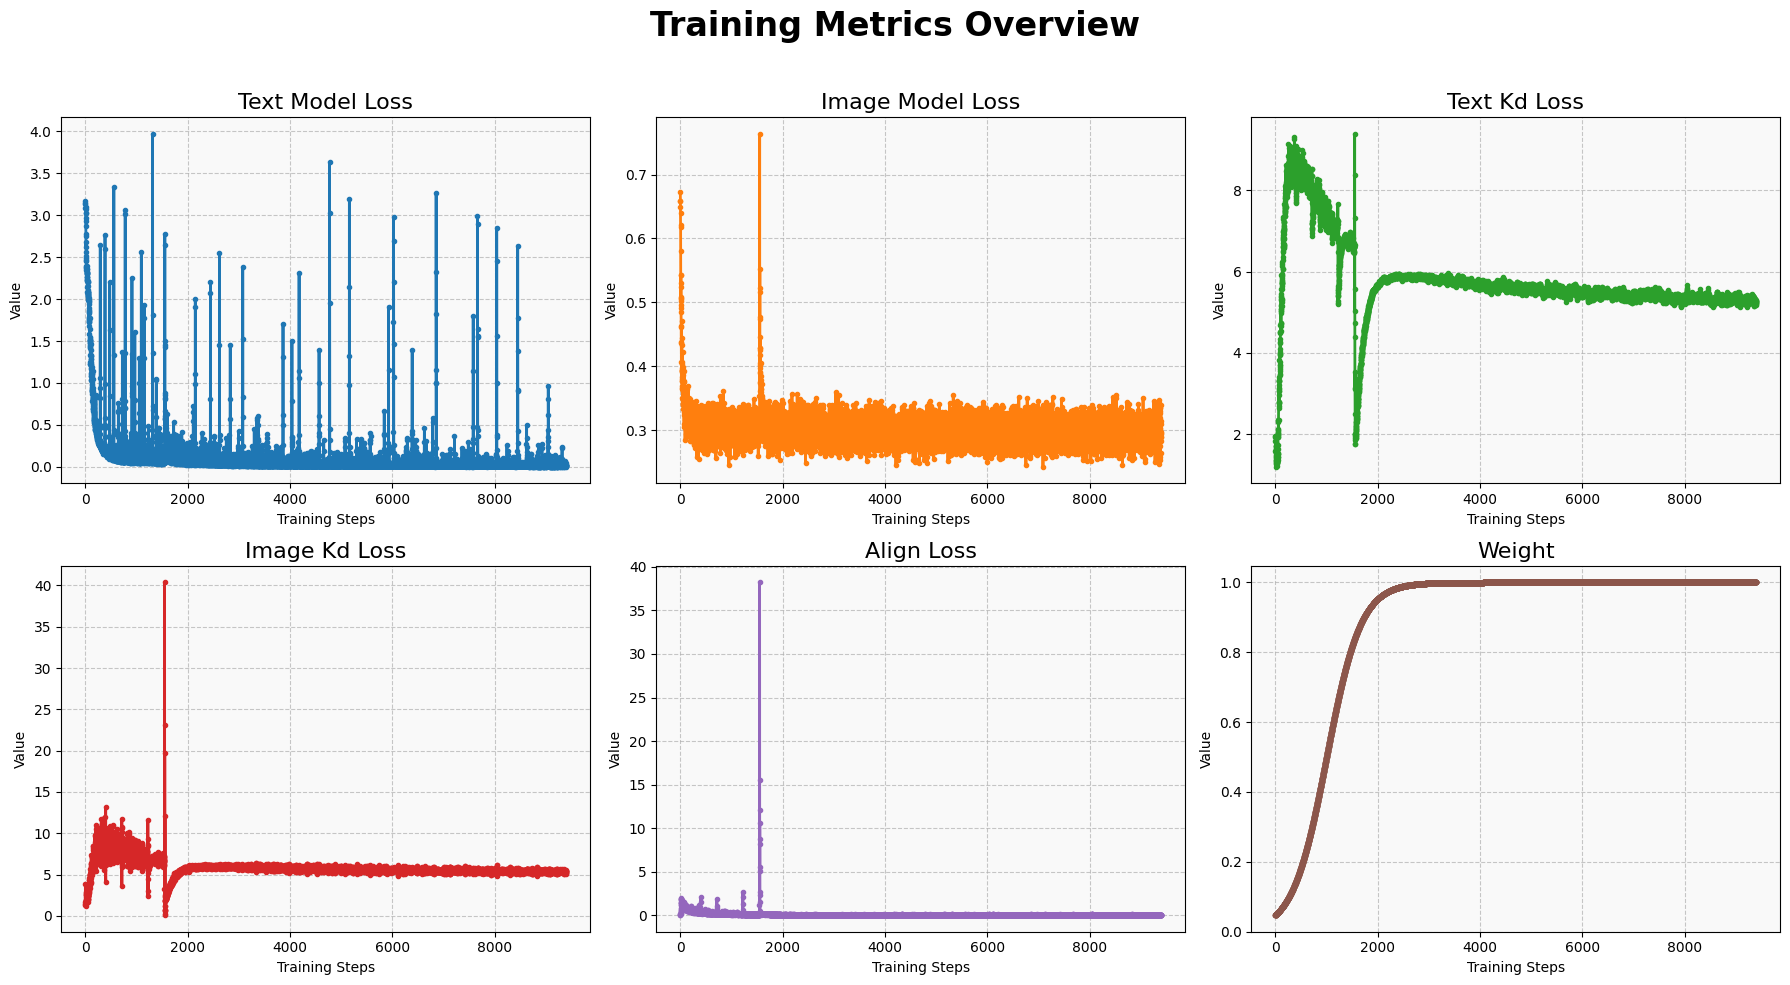

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training Metrics Overview', fontsize=24, fontweight='bold')

axes = axes.flatten()

for idx, (key, values) in enumerate(metrics.items()):
    axes[idx].plot(values, color=f'C{idx}', marker='o', markersize=3, linewidth=2)
    axes[idx].set_title(key.replace('_', ' ').title(), fontsize=16)
    axes[idx].set_xlabel('Training Steps')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, linestyle='--', alpha=0.7)
    axes[idx].set_facecolor('#f9f9f9')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Performance

In [26]:
def transform_to_text(output):
    return ' '.join(dataset.tokenizer.decode(output.numpy().tolist()[0]))

In [27]:
image_model.to('cpu')
text_model.to('cpu')

image_model.eval()
text_model.eval()

TextVAE(
  (embedding): Embedding(24, 64)
  (encoder): BidirectionalEncoder(
    (encoder): GRU(64, 64, batch_first=True, bidirectional=True)
    (mu_proj): Sequential(
      (0): Linear(in_features=128, out_features=30, bias=True)
    )
    (sigma_proj): Sequential(
      (0): Linear(in_features=128, out_features=30, bias=True)
    )
  )
  (decoder): AutoregressiveDecoder(
    (embedding): Embedding(24, 64)
    (proj_h): Linear(in_features=30, out_features=64, bias=True)
    (decoder): GRU(64, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=24, bias=True)
  )
)

In [28]:
count = 20
results = {'input': [], 'output': []}

for i, (image, sentence) in enumerate(dataset):
    input = sentence.unsqueeze(0)

    output, mu, sigma = text_model(input)
    output = output.argmax(dim=-1)
    
    input = transform_to_text(input)
    output = transform_to_text(output)

    results['input'].append(input)
    results['output'].append(output)

    print(f"Sample {i}")
    print("Original:", input[:-5])
    print("Reconstructed:", output.split("<eos>")[0])
    print()

    if count == 0:
        break

    count -= 1

Sample 0
Original: a photo of a ankle boot 
Reconstructed: a photo of a ankle boot 

Sample 1
Original: t-shirt 
Reconstructed: a t-shirt 

Sample 2
Original: t-shirt in a picture 
Reconstructed: t-shirt 

Sample 3
Original: a fashion item called dress 
Reconstructed: a photo of a dress 

Sample 4
Original: a fashion item called t-shirt 
Reconstructed: a fashion item called t-shirt 

Sample 5
Original: a photo of a pullover 
Reconstructed: a fashion item called pullover 

Sample 6
Original: image of a sneaker 
Reconstructed: sneaker 

Sample 7
Original: a photo of a pullover 
Reconstructed: a fashion item called pullover 

Sample 8
Original: sandal in a picture 
Reconstructed: a sandal 

Sample 9
Original: sandal in a picture 
Reconstructed: sandal in a picture 

Sample 10
Original: t-shirt 
Reconstructed: a t-shirt 

Sample 11
Original: a photo of a ankle boot 
Reconstructed: a fashion item called ankle boot 

Sample 12
Original: image of a sandal 
Reconstructed: sandal in a picture 


In [29]:
import numpy as np

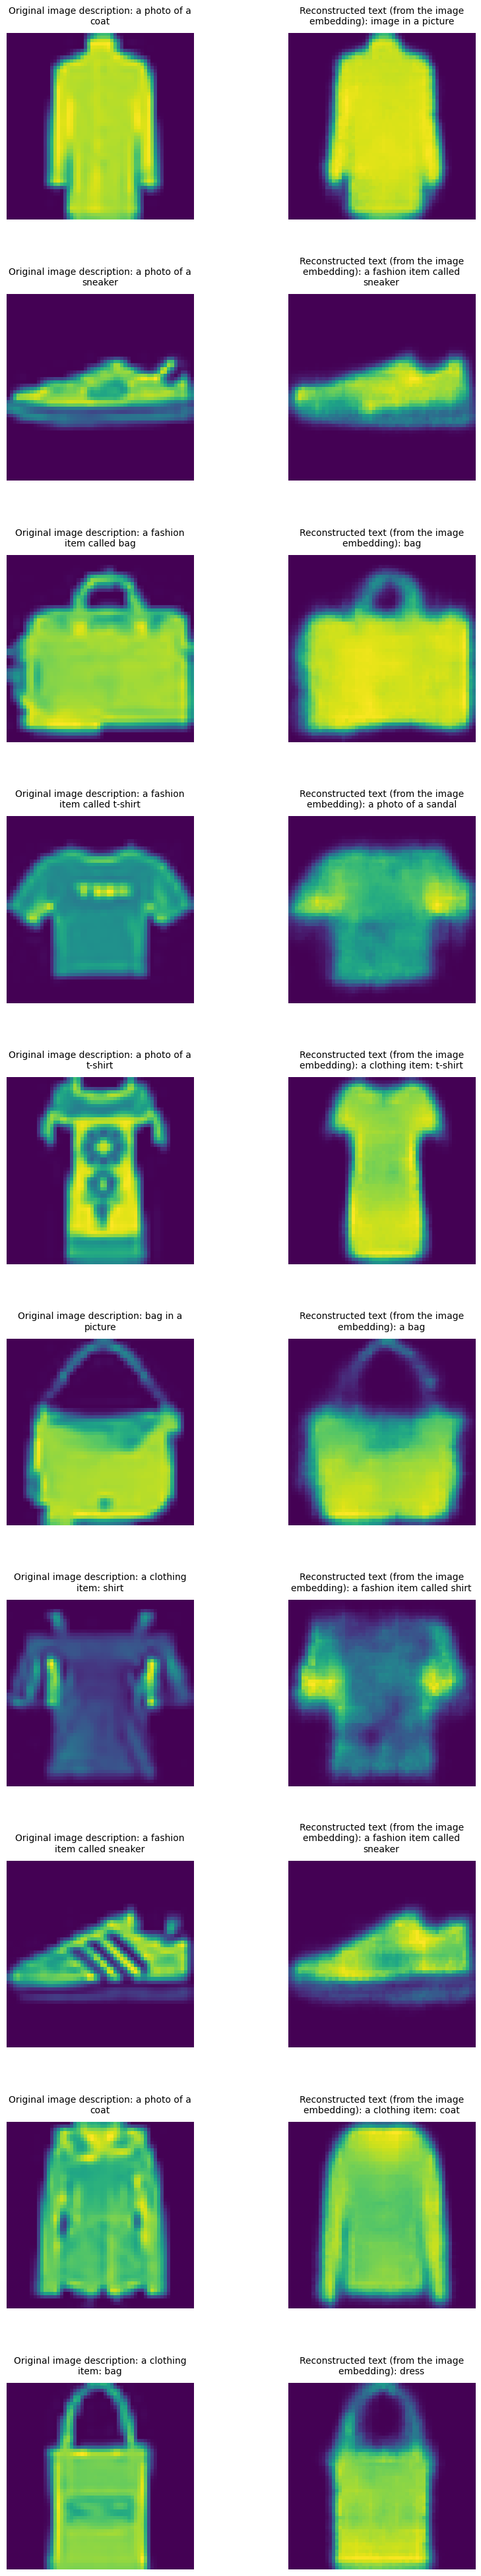

In [30]:
import textwrap

count = 0
fig, axs = plt.subplots(10, 2, figsize=(10, 40))

for idx, (img, desc) in enumerate(loader):
    if count == 10:
        break

    recon, mu, sigma = image_model(img)
    z = image_model.reparametrize(mu, sigma)
    text_recon = text_model.decode(z)

    b = recon[0].reshape((1, 56, 56))

    desc_text = transform_to_text(desc).split(' <eos>')[0]
    text_recon = text_recon.argmax(dim=-1)
    text_recon_text = transform_to_text(text_recon).split(' <eos>')[0]

    axs[idx, 0].imshow(img[0].permute(1, 2, 0).squeeze().detach().cpu().numpy())
    axs[idx, 1].imshow(b.permute(1, 2, 0).detach().cpu().numpy())

    original_text_wrapped = "\n".join(textwrap.wrap(f"Original image description:\n{desc_text}", width=40))
    recon_text_wrapped = "\n".join(textwrap.wrap(f"Reconstructed text (from the image embedding):\n{text_recon_text}", width=40))

    axs[idx, 0].set_title(original_text_wrapped, fontsize=10, pad=10)
    axs[idx, 1].set_title(recon_text_wrapped, fontsize=10, pad=10)

    # Ocultar ejes
    axs[idx, 0].axis('off')
    axs[idx, 1].axis('off')

    count += 1

plt.tight_layout(pad=4.0)
plt.show()

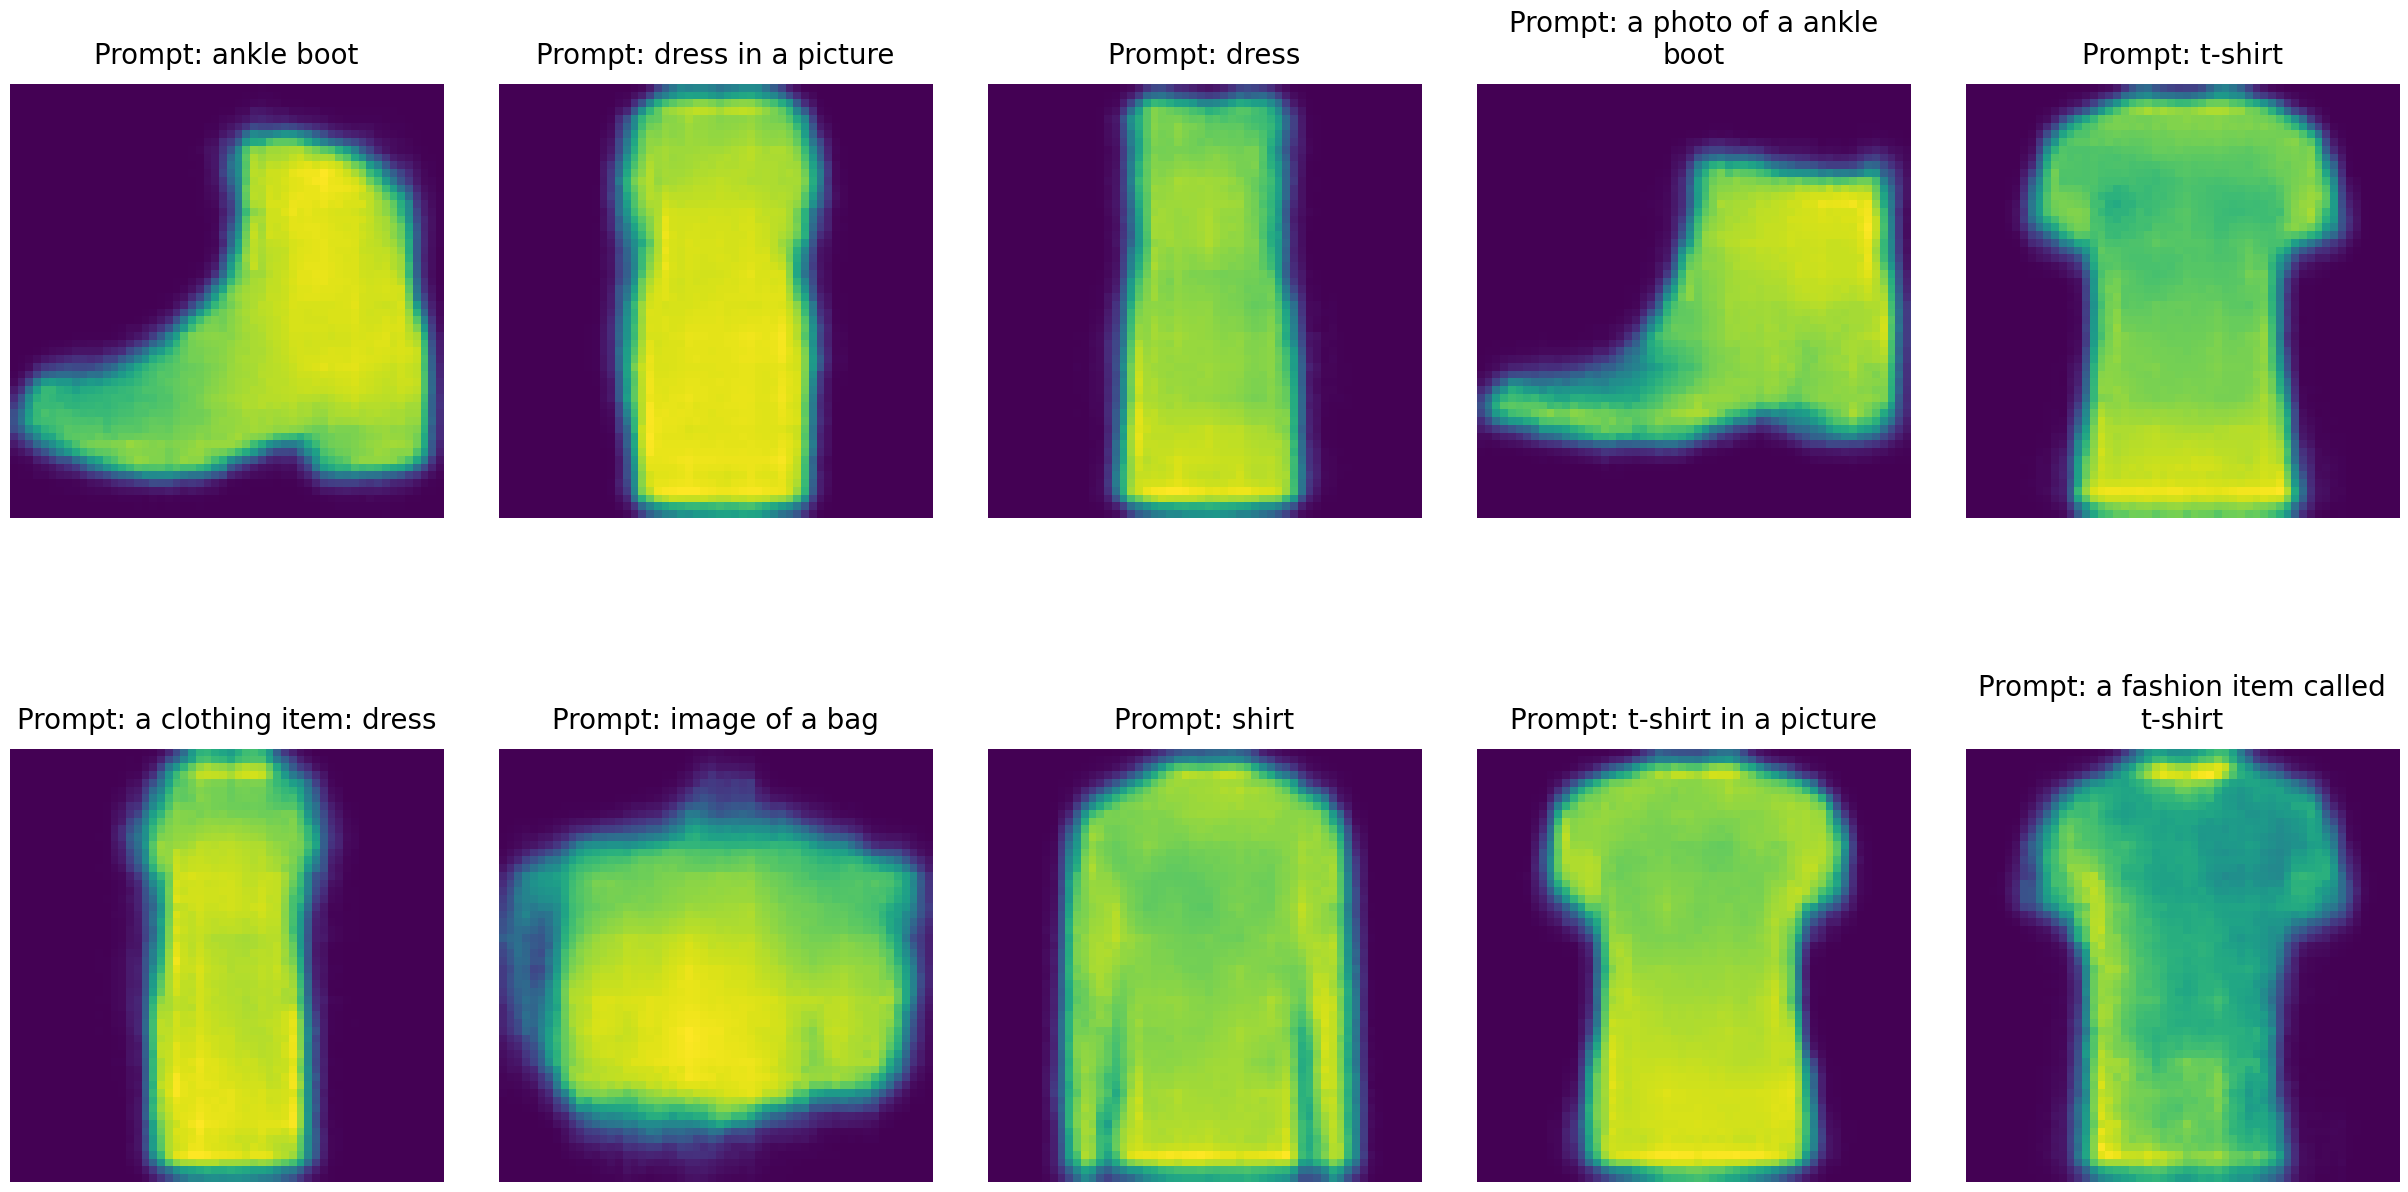

In [31]:
import matplotlib.pyplot as plt
import textwrap

count = 0
fig, axs = plt.subplots(2, 5, figsize=(25, 15))  # Aumenté un poco la altura a 10
axs = axs.flatten()

for idx, (img, desc) in enumerate(loader):
    if count == 10:
        break

    _, mu, sigma = text_model(desc)
    z = text_model.reparametrize(mu, sigma)

    img_recon = image_model.decode(z)
    b = img_recon[0].reshape((1, 56, 56))

    desc_text = transform_to_text(desc).split(' <eos>')[0]

    wrapped_text = "\n".join(textwrap.wrap(f"Prompt: {desc_text}", width=30))

    axs[idx].imshow(b.permute(1, 2, 0).detach().cpu().numpy())
    axs[idx].set_title(wrapped_text, fontsize=20, pad=15)
    axs[idx].axis('off')

    count += 1

plt.tight_layout(pad=4.0)
plt.show()

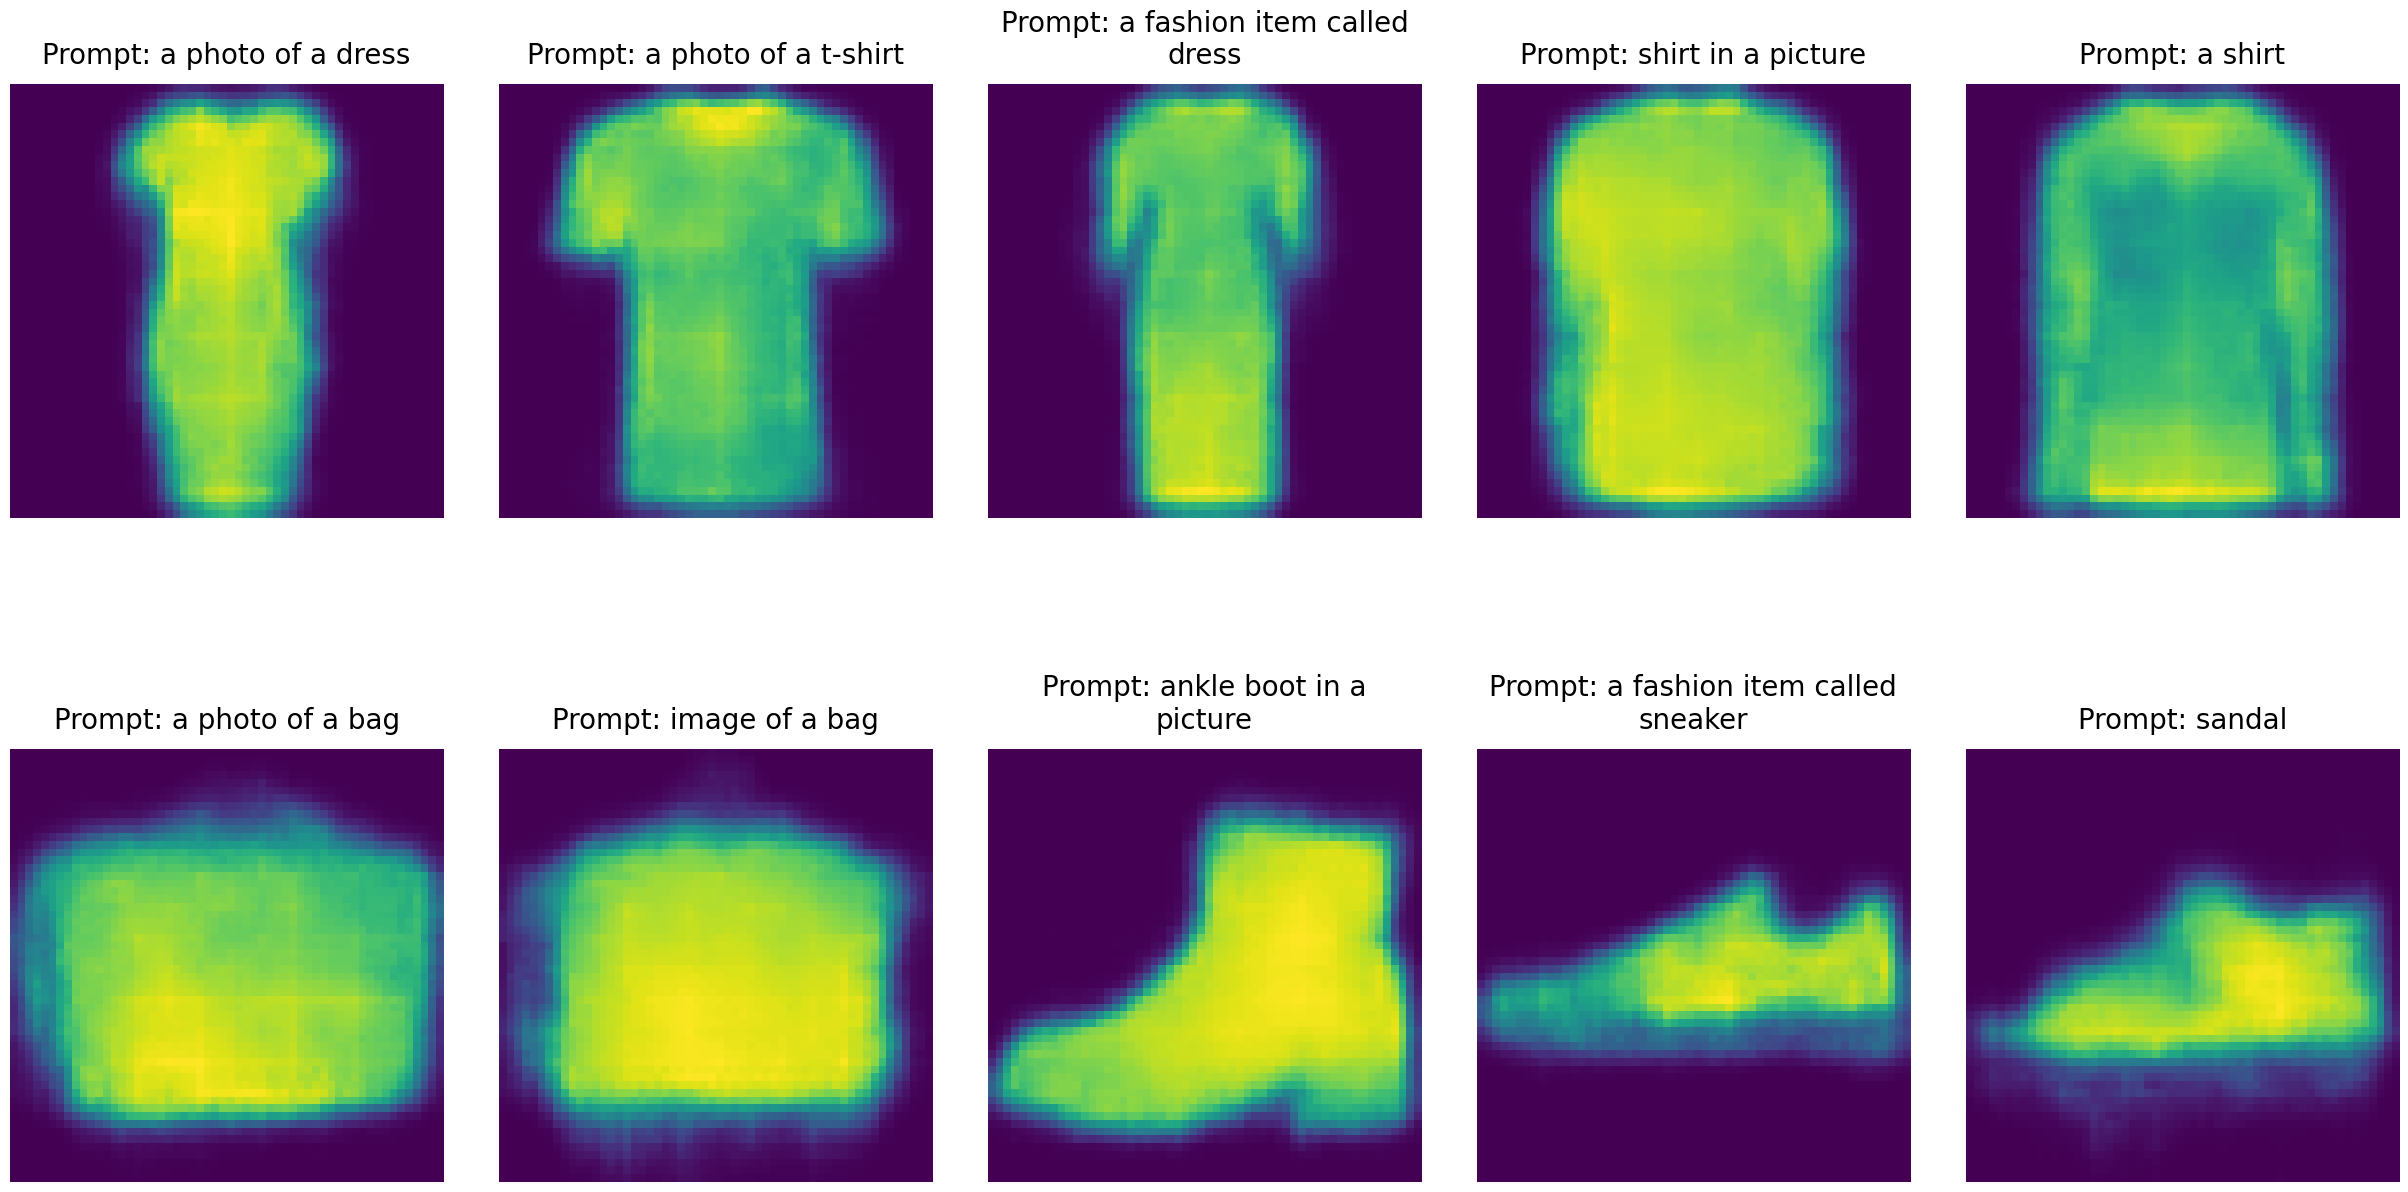

In [32]:
count = 0
fig, axs = plt.subplots(2, 5, figsize=(25, 15))
axs = axs.flatten()

for idx, (img, desc) in enumerate(loader):
    if count == 10:
        break

    _, mu, sigma = text_model(desc)
    z = text_model.reparametrize(mu, sigma)

    img_recon = image_model.decode(z)
    b = img_recon[0].reshape((1, 56, 56))

    desc_text = transform_to_text(desc).split(' <eos>')[0]

    wrapped_text = "\n".join(textwrap.wrap(f"Prompt: {desc_text}", width=30))

    axs[idx].imshow(b.permute(1, 2, 0).detach().cpu().numpy())
    axs[idx].set_title(wrapped_text, fontsize=20, pad=15)
    axs[idx].axis('off')

    count += 1

plt.tight_layout(pad=4.0)
plt.show()

# Interpolación

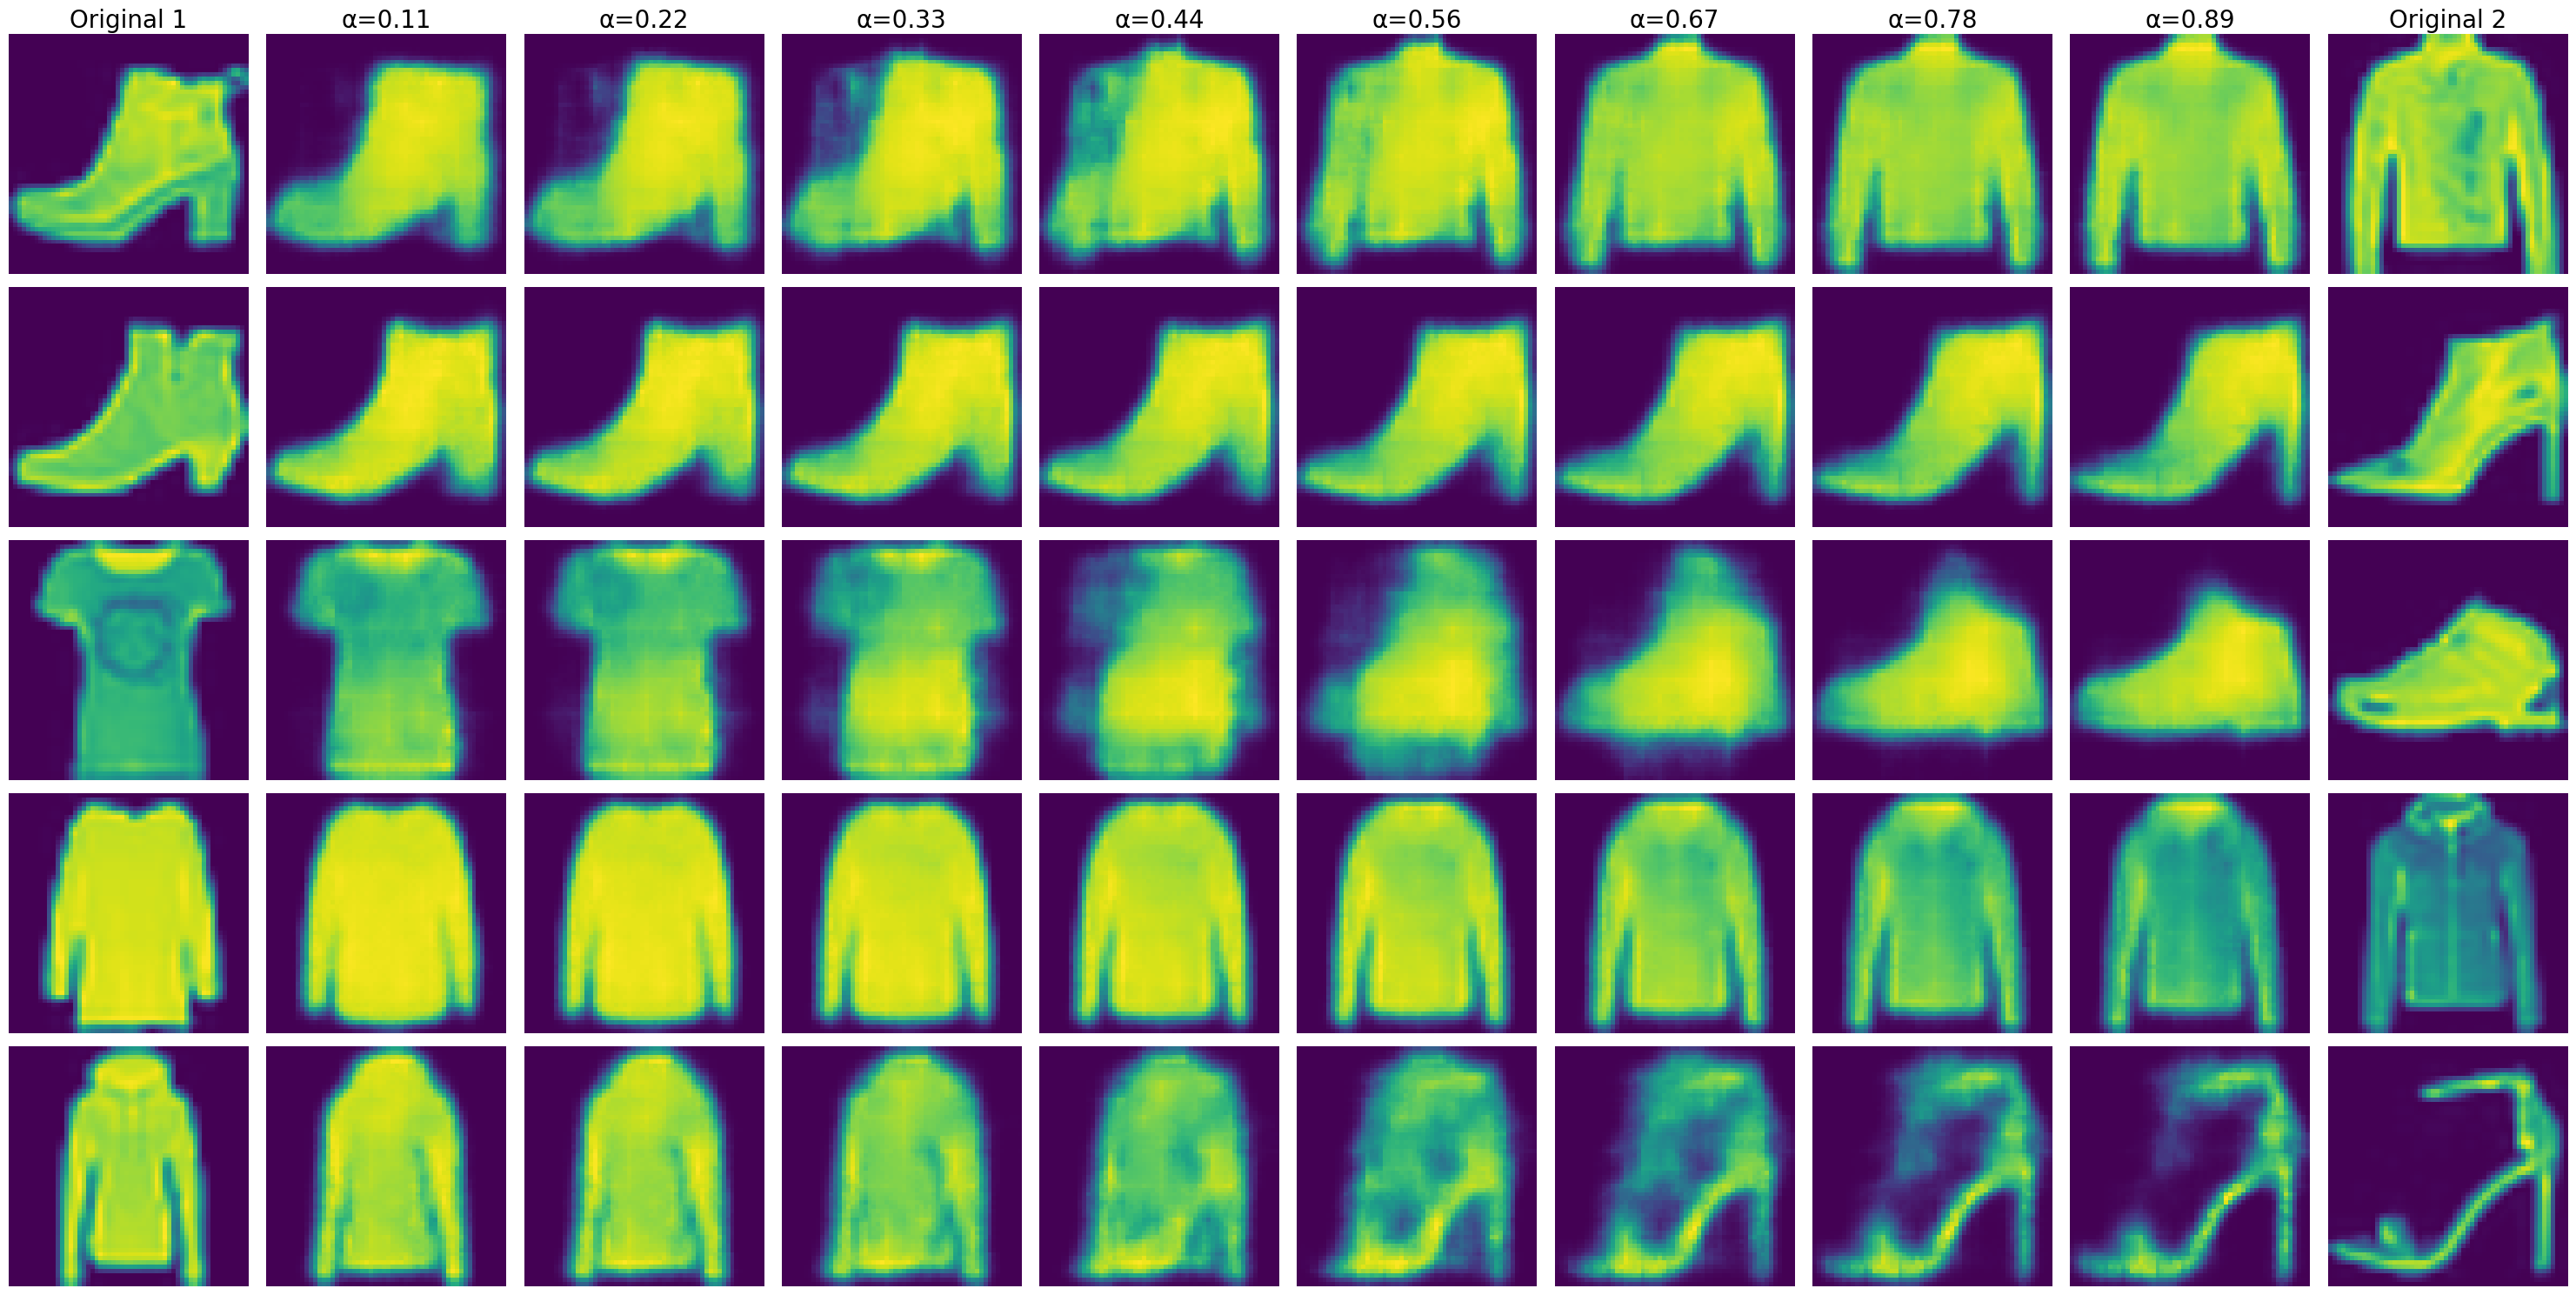

In [34]:
fig, axs = plt.subplots(5, 10, figsize=(30, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for row in range(5):
    img1, _ = next(iter(loader))
    img2, _ = next(iter(loader))

    _, mu1, sigma1 = image_model(img1)
    _, mu2, sigma2 = image_model(img2)

    z1 = image_model.reparametrize(mu1, sigma1)
    z2 = image_model.reparametrize(mu2, sigma2)

    n_steps = 8
    alphas = torch.linspace(0, 1, n_steps + 2)

    for col, alpha in enumerate(alphas):
        ax = axs[row, col]

        if alpha == 0:
            img_to_show = img1[0]
            title = "Original 1"
        elif alpha == 1:
            img_to_show = img2[0]
            title = "Original 2"
        else:
            z_interp = (1 - alpha) * z1 + alpha * z2
            img_interp = image_model.decode(z_interp)
            img_to_show = img_interp[0]
            title = f"α={alpha:.2f}"

        img_to_show = img_to_show.reshape((1, 56, 56))
        ax.imshow(img_to_show.permute(1, 2, 0).detach().cpu().numpy())
        ax.axis('off')

        if row == 0:
            ax.set_title(title, fontsize=20)

plt.tight_layout()
plt.show()

In [35]:
def transform_to_text(output):
    return ' '.join(dataset.tokenizer.decode(output.numpy().tolist()[0]))

for row in range(5):
    _, phrase1 = next(iter(loader))
    _, phrase2 = next(iter(loader))

    _, mu1, sigma1 = wrapper(phrase1[0].unsqueeze(0))
    _, mu2, sigma2 = wrapper(phrase2[0].unsqueeze(0))

    z1 = wrapper.model.reparametrize(mu1, sigma1)
    z2 = wrapper.model.reparametrize(mu2, sigma2)

    n_steps = 8
    alphas = torch.linspace(0, 1, n_steps + 2)

    print(f"\n--- Interpolación {row+1} ---")

    for alpha in alphas:
        z_interp = (1 - alpha) * z1 + alpha * z2

        text_output = wrapper.model.decode(z_interp)
        text_output = text_output.argmax(dim=-1)
        text_text = transform_to_text(text_output).split('<eos>')[0]

        print(f"α={alpha:.2f}: {text_text}")


--- Interpolación 1 ---
α=0.00: bag in a picture 
α=0.11: bag in a picture 
α=0.22: image in a picture 
α=0.33: image of a picture 
α=0.44: image of a bag 
α=0.56: image of a coat 
α=0.67: image of a coat 
α=0.78: image of a coat 
α=0.89: image of a coat 
α=1.00: image of a coat 

--- Interpolación 2 ---
α=0.00: a photo of a dress 
α=0.11: a photo of a dress 
α=0.22: a photo of a dress 
α=0.33: image of a a 
α=0.44: image of a sandal 
α=0.56: image of a sandal 
α=0.67: image of a sandal 
α=0.78: image of a ankle boot 
α=0.89: image of a ankle boot 
α=1.00: image of a ankle boot 

--- Interpolación 3 ---
α=0.00: a clothing item: coat 
α=0.11: a clothing item: coat 
α=0.22: a clothing item: coat 
α=0.33: a clothing item: coat 
α=0.44: a clothing item: shirt 
α=0.56: a clothing item: shirt 
α=0.67: shirt 
α=0.78: shirt 
α=0.89: shirt 
α=1.00: shirt 

--- Interpolación 4 ---
α=0.00: dress 
α=0.11: dress 
α=0.22: dress 
α=0.33: a clothing item: dress 
α=0.44: a clothing item: dress 
α=0.56

In [36]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import torch

text_labels = [
            "t-shirt", "trouser", "pullover", "dress", "coat",
            "sandal", "shirt", "sneaker", "bag", "ankle boot"
        ]
latents = []
labels = []

with torch.no_grad():
    for img, seq in loader:
        _, mu, _ = image_model(img.to(device))

        for i, s in enumerate(seq):
            text_decoded = transform_to_text(s.unsqueeze(0)).lower()
            found_label = next((label for label in text_labels if label in text_decoded), None)

            if found_label:
                latents.append(mu[i].cpu())
                labels.append(found_label)

latents = torch.stack(latents, dim=0)

text_embeddings = []

with torch.no_grad():
    for label in text_labels:
        tokens = torch.tensor(dataset.tokenizer.encode(f"{label} <eos>")).unsqueeze(0).to(device)
        _, mu, _ = text_model(tokens)
        mu = mu.squeeze(0)
        text_embeddings.append(mu.cpu())

text_embeddings = torch.stack(text_embeddings, dim=0)

all_latents = torch.cat([latents, text_embeddings], dim=0)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
all_latents_2d = tsne.fit_transform(all_latents.numpy())

img_latents_2d = all_latents_2d[:len(latents)]
text_latents_2d = all_latents_2d[len(latents):]

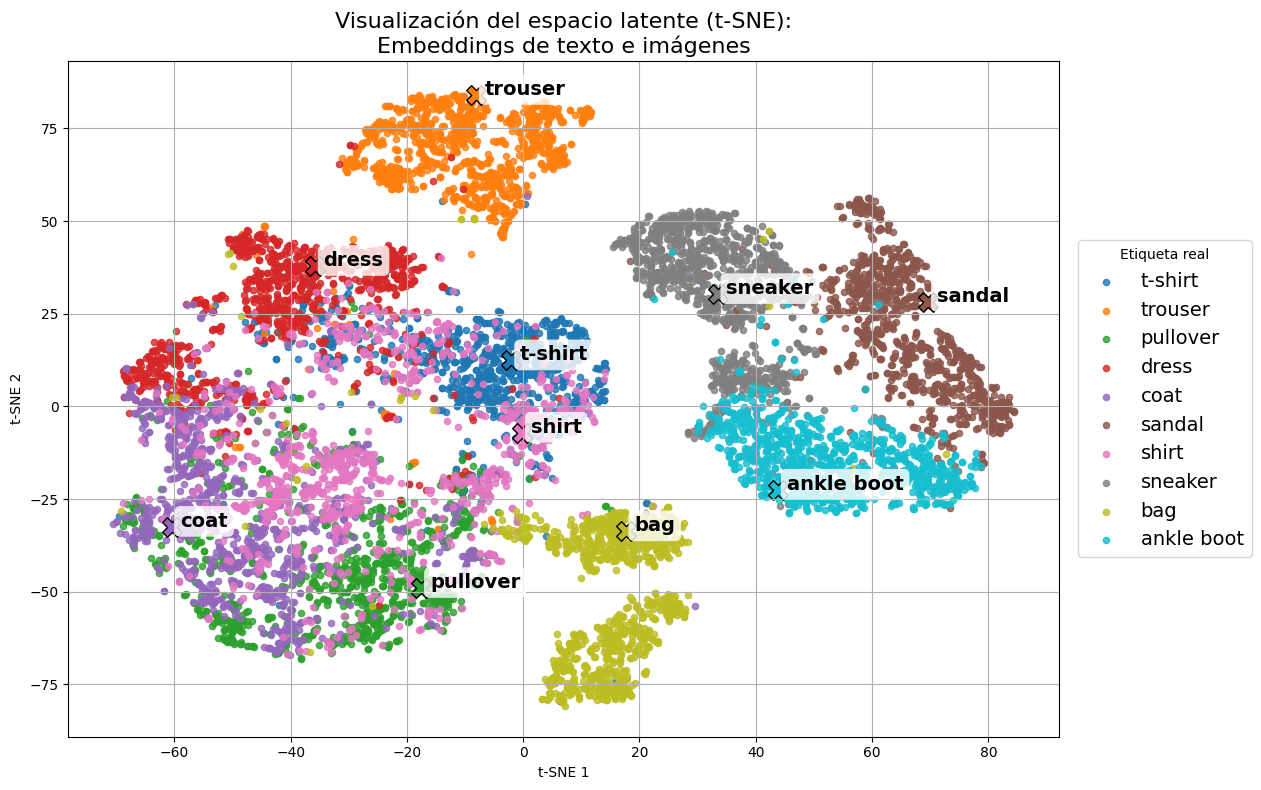

In [37]:
plt.figure(figsize=(15,8))
palette = sns.color_palette("tab10", len(text_labels))
label_to_color = {label: palette[i] for i, label in enumerate(text_labels)}

for label in text_labels:
    idxs = [i for i, l in enumerate(labels) if l == label]
    if idxs:
        coords = img_latents_2d[idxs]
        plt.scatter(coords[:, 0], coords[:, 1], label=label, alpha=0.8, s=20, color=label_to_color[label])

for i, (x, y) in enumerate(text_latents_2d):
    plt.scatter(x, y, marker='X', s=200, color=palette[i], edgecolor='black')
    
    plt.text(x + 1.5, y, text_labels[i],
             fontsize=14, fontweight='bold', color='black',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))

plt.title("Visualización del espacio latente (t-SNE):\nEmbeddings de texto e imágenes", fontsize=16)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(
    title="Etiqueta real",
    fontsize=14,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.grid(True)
plt.show()

# Evaluation

In [38]:
from playground.evaluators import MixedFashionMNISTEvaluator, MixedPerplexityEvaluator

/Users/ricardojuancardenesperez/anaconda3/envs/xlstm_up/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
evaluator = MixedFashionMNISTEvaluator(image_model, text_model, loader, dataset.tokenizer, device='cpu', evaluator_path="models/evaluators/fashion_mnist_cnn.pth")

In [41]:
image_to_text_acc, text_to_image_acc = evaluator.evaluate()
print(f"Image-to-text accuacy: {round(image_to_text_acc*100,2)}%")
print(f"Text-to-image accuacy: {round(text_to_image_acc*100,2)}%")

Image-to-text accuacy: 67.82%
Text-to-image accuacy: 76.8%


In [42]:
evaluator = MixedPerplexityEvaluator(image_model, text_model, loader, dataset.tokenizer, device='cpu')

In [43]:
image_to_text_perp, text_to_image_perp = evaluator.evaluate()
print(f"Image-to-text perplexity: {round(image_to_text_perp,2)}")
print(f"Text reconstruction perplexity: {round(text_to_image_perp,2)}")

Image-to-text perplexity: 42.35
Text reconstruction perplexity: 41.13
